In [53]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-14 19:55:51--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy.1’

mnist_test_seq.npy. 100%[===================>] 781.25M  16.0MB/s    in 51s     

2020-05-14 19:56:43 (15.2 MB/s) - ‘mnist_test_seq.npy.1’ saved [819200096/819200096]



In [0]:
# Useful libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

In [0]:
def shape_to_patch(img_tensor, patch_size):
  N, F, H, W, C = img_tensor.shape
  aux = np.reshape(img_tensor, [N, F,
                                H//patch_size, patch_size,
                                W//patch_size, patch_size,
                                C])
  aux = np.transpose(aux, [0,1,2,4,3,5,6])
  patch_tensor = np.reshape(aux, [N, F,
                                  H//patch_size,
                                  W//patch_size,
                                  patch_size*patch_size*C])
  return patch_tensor

def shape_to_img(patch_tensor, patch_size):
  F, Hp, Wp, Cp = patch_tensor.shape
  C = Cp // (patch_size*patch_size)
  aux = np.reshape(patch_tensor, [F,
                                  Hp, Wp,
                                  patch_size, patch_size,
                                  C])
  aux = np.transpose(aux, [0,1,3,2,4,5])
  img_tensor = np.reshape(aux, [F,
                                Hp * patch_size,
                                Wp * patch_size,
                                C])
  return img_tensor

In [0]:
#
# Parameters
#
Nsample = 500
Npatch = 4
Ninput = 10
Noutput = 10
loss = 'binary_crossentropy'
#loss = 'mse'

In [160]:
#
# Data processing
#
data = np.load('mnist_test_seq.npy')
data = data.swapaxes(0, 1) # swap frames and instances for tf handling
data = data[:Nsample, :, :, :] # reduce memory and compute requirements by selecting a subsample
data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
data = data/np.amax(data) # minmax normalize data
data = tf.cast(data, tf.float32) # convert to float32 for tf handling
data = shape_to_patch(data, Npatch) # put into patches
N, F, H, W, C = data.shape # save dims
print('(instance, frame, height, width, channel) = '+str(data.shape))
print('min value = '+str(np.amin(data)))
print('max value = '+str(np.amax(data)))

(instance, frame, height, width, channel) = (500, 20, 16, 16, 16)
min value = 0.0
max value = 1.0


In [161]:
#
# Create Input/output dataset: 
# previous frame (X_t-1) is used as input to predict next frame (y_t)
#
def shift_data(data, cutoff):
  X = data[:, :cutoff, :, :, :]
  y = data[:, 1:cutoff+1, :, :, :]
  return X, y
X, y = shift_data(data, Ninput)
print("X is:", X.shape)
print("y is:", y.shape)

X is: (500, 10, 16, 16, 16)
y is: (500, 10, 16, 16, 16)


In [0]:
# Our Model Architecture
def model_init():
    inputs = tf.keras.Input(shape=[None, H, W, C])
    # Encoder
    CL1, cl1_h, cl1_c = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                                   return_sequences=True, return_state=True)(inputs)
    CL2, cl2_h, cl2_c = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                                   return_sequences=True, return_state=True)(CL1)
    # Decoder
    CL3 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     return_sequences=True)(CL1, initial_state=[cl1_h, cl1_c])
    concat1 = tf.keras.layers.Concatenate()([CL2, CL3])
    CL4 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     return_sequences=True)(concat1, initial_state=[cl2_h, cl2_c])
    # Prediction
    concat2 = tf.keras.layers.Concatenate()([CL3, CL4])
    preds = tf.keras.layers.Conv3D(16, 1, padding='same', activation='sigmoid')(concat2)
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Custom metrics
def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [164]:
# Initialize model
model = model_init()
# Build optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss,
              metrics=['acc', 'binary_accuracy', 'cosine_similarity', 
                       'binary_crossentropy', 'logcosh', 'mae', 'mse',
                       tf.keras.metrics.FalseNegatives(name='FN'), 
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.TrueNegatives(name='TN'), 
                       tf.keras.metrics.TruePositives(name='TP'),
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall'),
                       ssim, psnr, cor])
# Fit the model
history = model.fit(X, y, batch_size=8, epochs=20, validation_split=0.1)

Epoch 1/20
57/57 [==============================] - 22s 383ms/step - loss: 0.0979 - acc: 0.0069 - binary_accuracy: 0.9168 - cosine_similarity: 0.0766 - binary_crossentropy: 0.2961 - logcosh: 0.0262 - mae: 0.0979 - mse: 0.0573 - FN: 1303189.0000 - FP: 214569.0000 - TN: 16899014.0000 - TP: 15229.0000 - prec: 0.0663 - recall: 0.0116 - ssim: 0.0380 - psnr: 13.1874 - cor: -0.0248 - val_loss: 0.0493 - val_acc: 0.0060 - val_binary_accuracy: 0.9316 - val_cosine_similarity: 0.0735 - val_binary_crossentropy: 0.2958 - val_logcosh: 0.0179 - val_mae: 0.0493 - val_mse: 0.0405 - val_FN: 139998.0000 - val_FP: 0.0000e+00 - val_TN: 1908002.0000 - val_TP: 0.0000e+00 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00 - val_ssim: 0.0552 - val_psnr: 14.0527 - val_cor: -9.1966e-04
Epoch 2/20
57/57 [==============================] - 20s 356ms/step - loss: 0.0510 - acc: 0.0058 - binary_accuracy: 0.9285 - cosine_similarity: 0.0765 - binary_crossentropy: 0.3318 - logcosh: 0.0189 - mae: 0.0510 - mse: 0.0428 - FN: 13

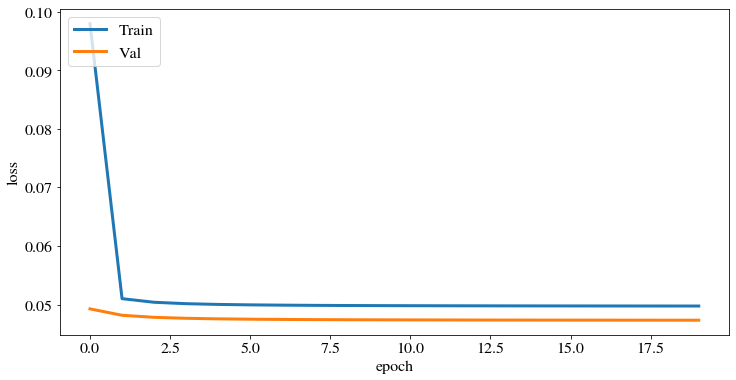

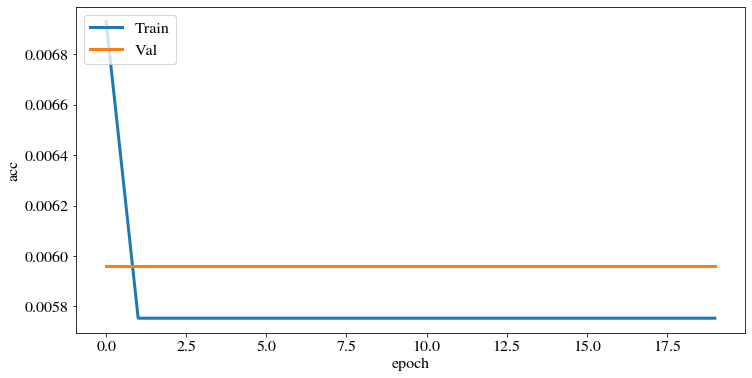

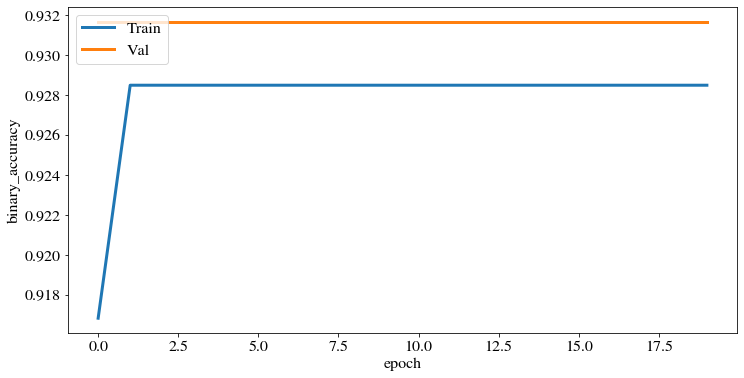

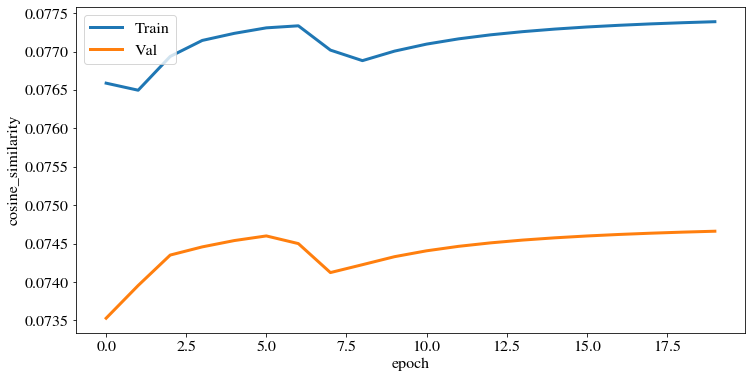

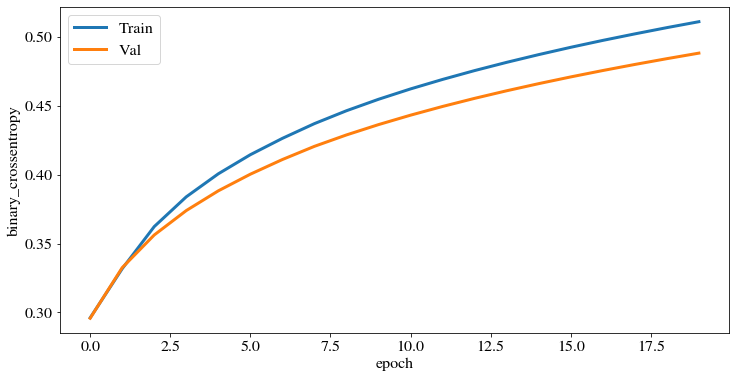

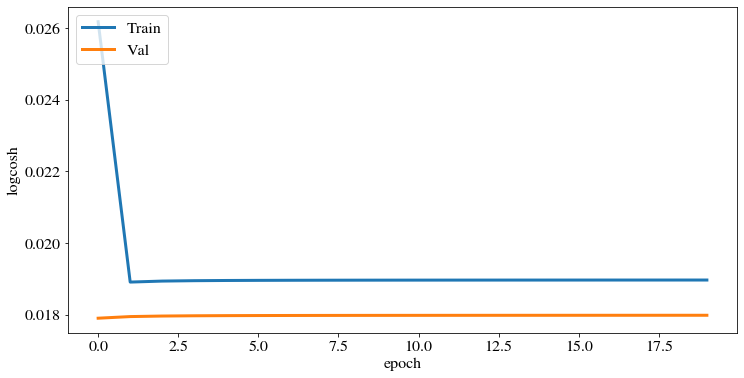

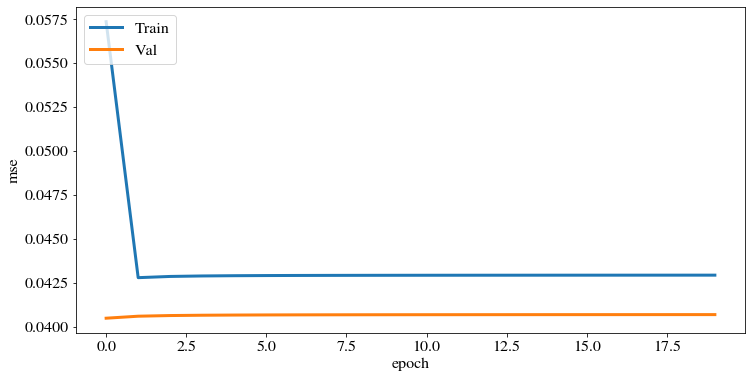

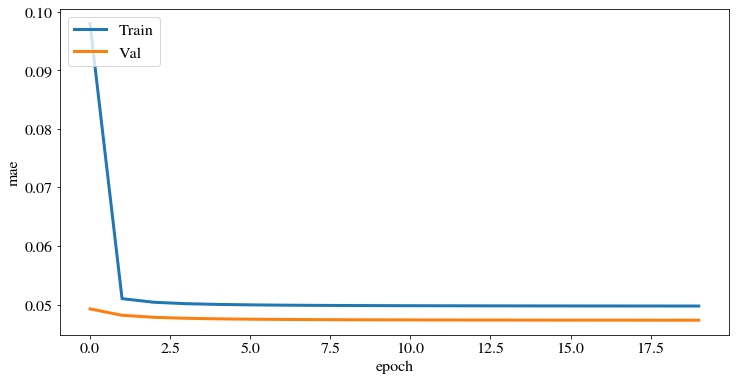

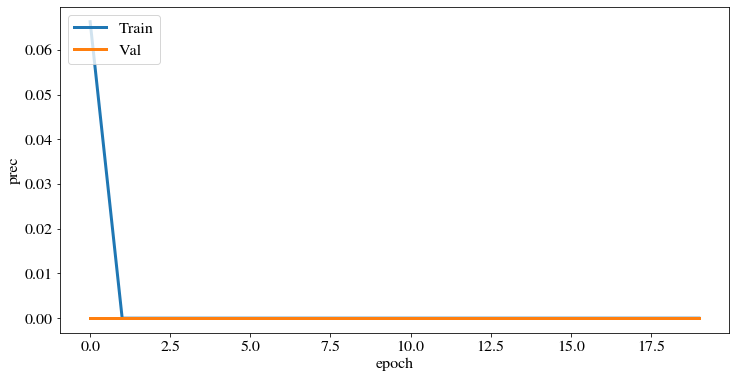

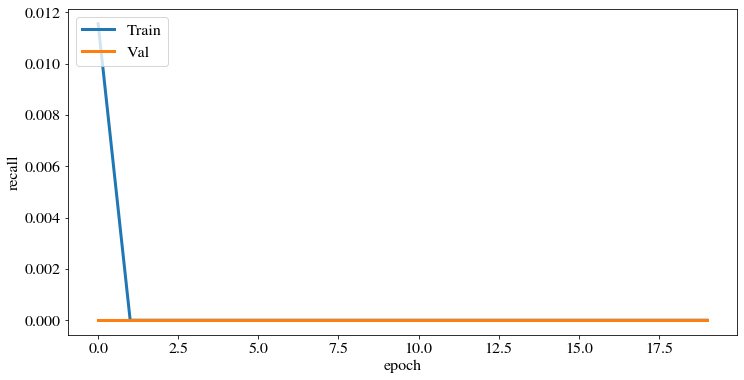

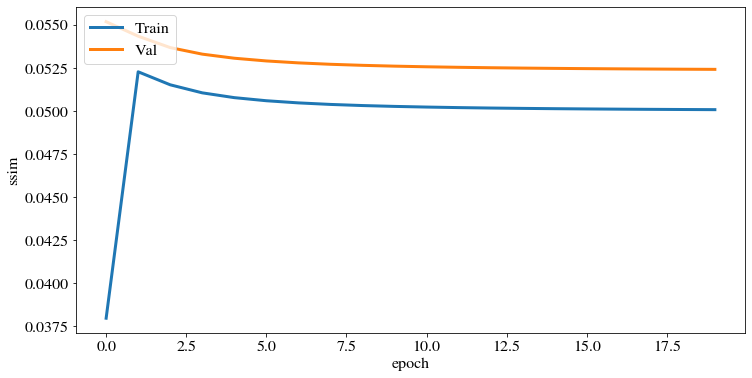

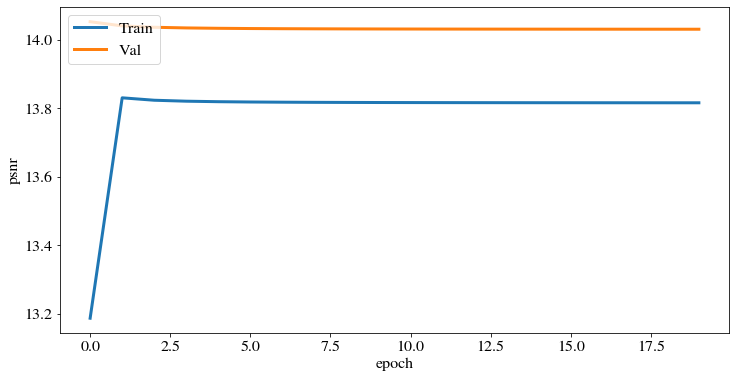

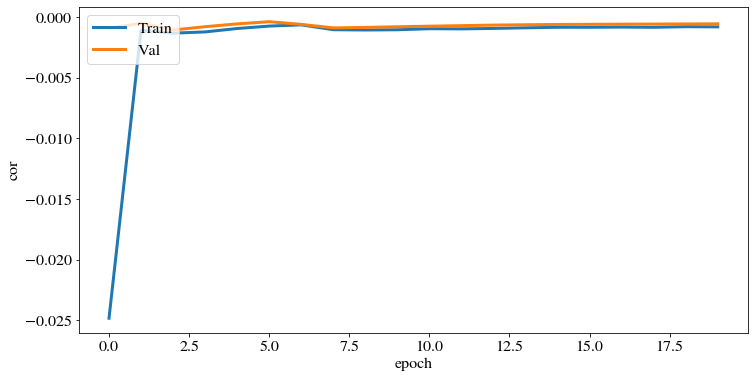

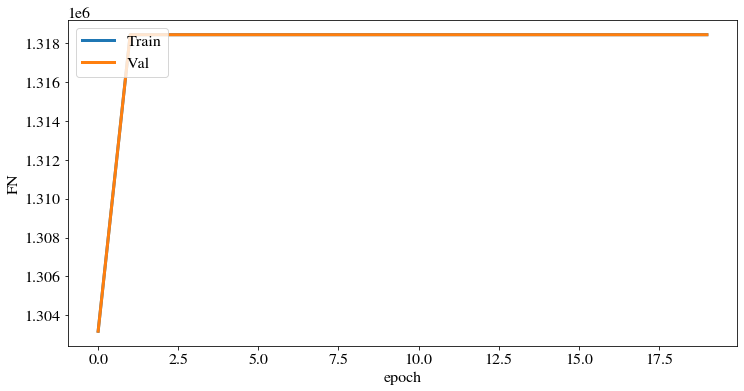

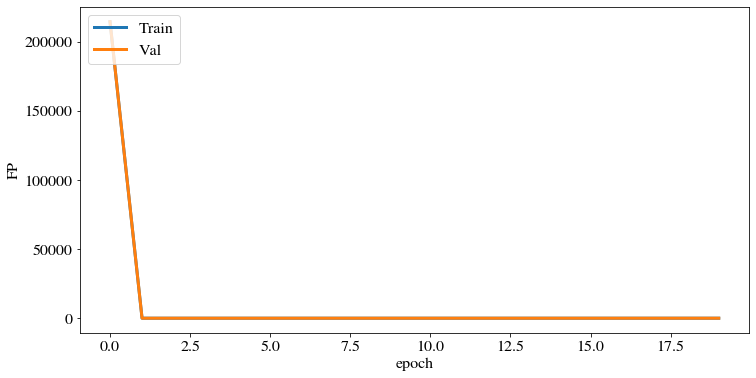

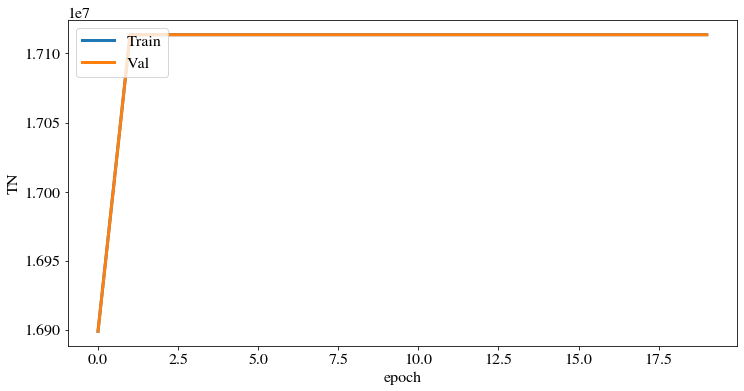

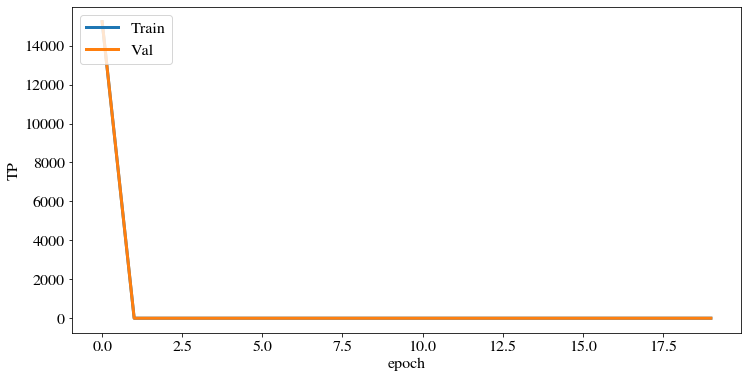

In [165]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_accuracy'], label='Train')
plt.plot(history.history['val_binary_accuracy'], label='Val')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('binary_accuracy.png')
files.download('binary_accuracy.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cosine_similarity'], label='Train')
plt.plot(history.history['val_cosine_similarity'], label='Val')
plt.ylabel('cosine_similarity')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cosine_similarity.png')
files.download('cosine_similarity.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_crossentropy'], label='Train')
plt.plot(history.history['val_binary_crossentropy'], label='Val')
plt.ylabel('binary_crossentropy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('binary_crossentropy.png')
files.download('binary_crossentropy.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['logcosh'], label='Train')
plt.plot(history.history['val_logcosh'], label='Val')
plt.ylabel('logcosh')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('logcosh.png')
files.download('logcosh.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['mse'], label='Train')
plt.plot(history.history['val_mse'], label='Val')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('mse.png')
files.download('mse.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Val')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('mae.png')
files.download('mae.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
files.download('psnr.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FN'], label='Train')
plt.plot(history.history['FN'], label='Val')
plt.ylabel('FN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FN.png')
files.download('FN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FP'], label='Train')
plt.plot(history.history['FP'], label='Val')
plt.ylabel('FP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FP.png')
files.download('FP.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TN'], label='Train')
plt.plot(history.history['TN'], label='Val')
plt.ylabel('TN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TN.png')
files.download('TN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TP'], label='Train')
plt.plot(history.history['TP'], label='Val')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TP.png')
files.download('TP.png')

In [166]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 50
track = X[itest, :, :, :, :]
for i in range(Noutput):
  new_pos = model.predict(track[None, :, :, :, :])
  track = np.concatenate((track, new_pos[:, -1, :, :, :]), axis=0)
track = shape_to_img(track, Npatch)
print("track:", track.shape)

track: (20, 64, 64, 1)


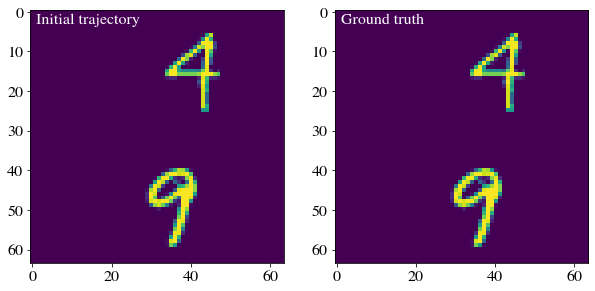

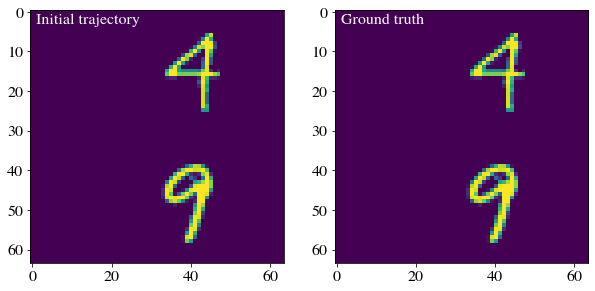

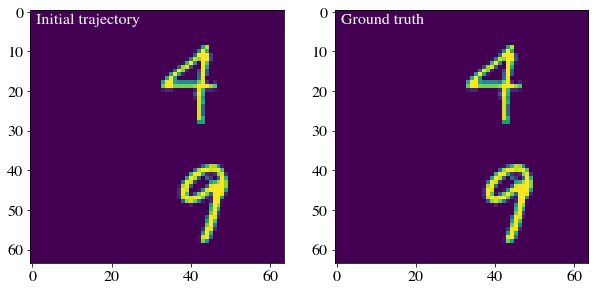

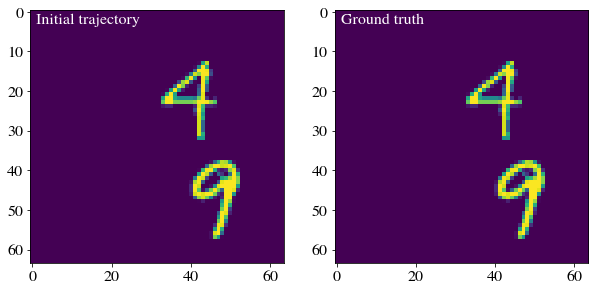

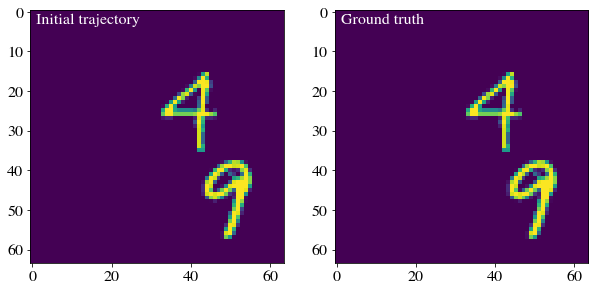

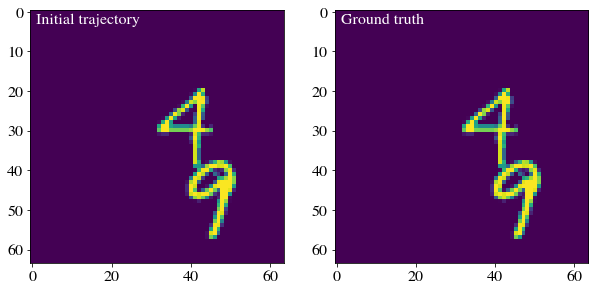

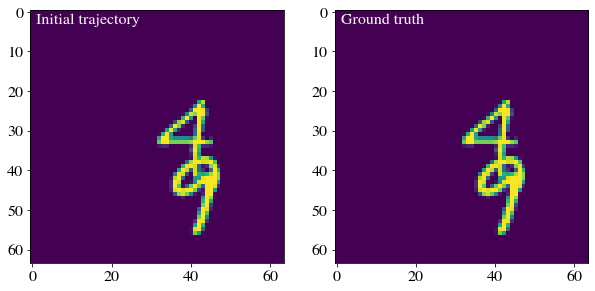

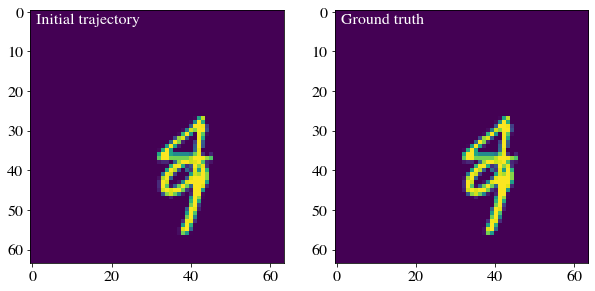

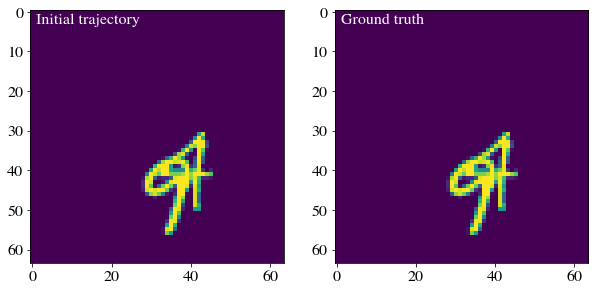

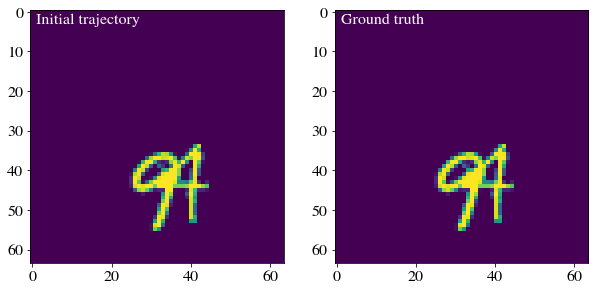

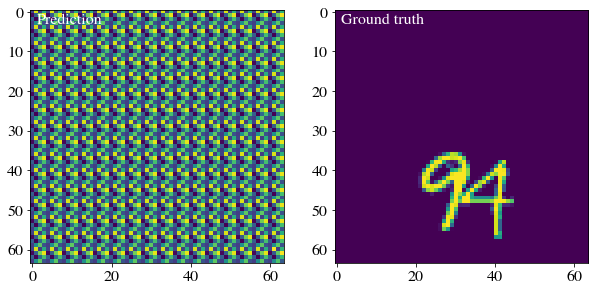

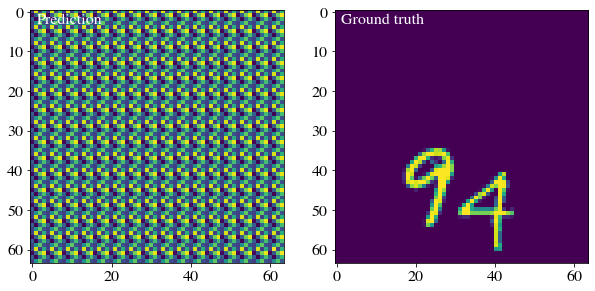

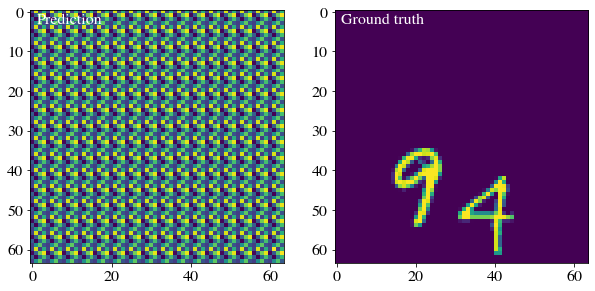

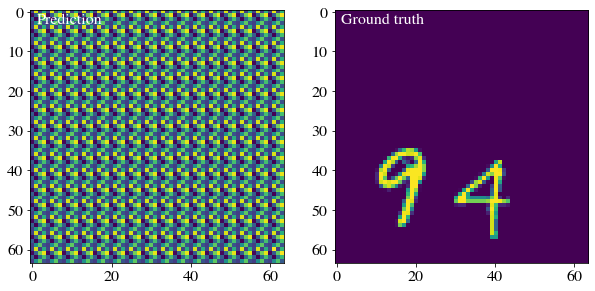

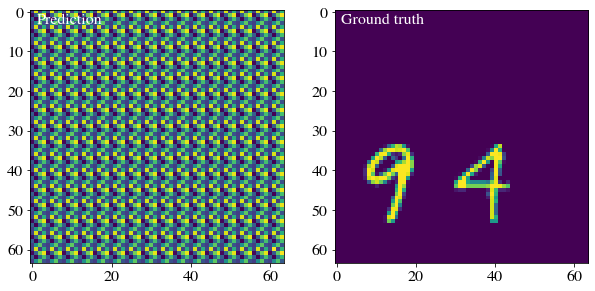

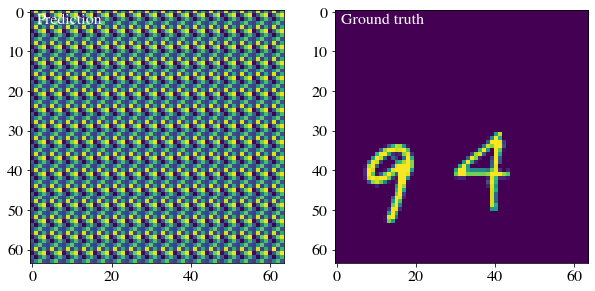

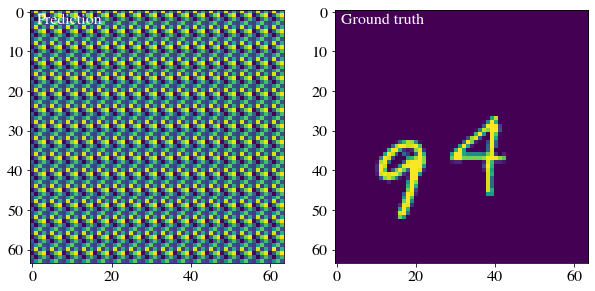

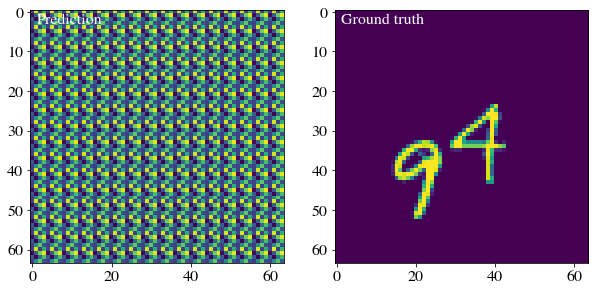

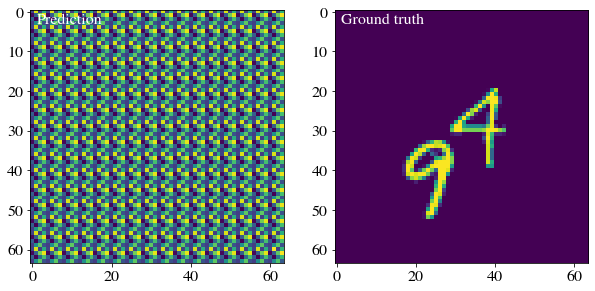

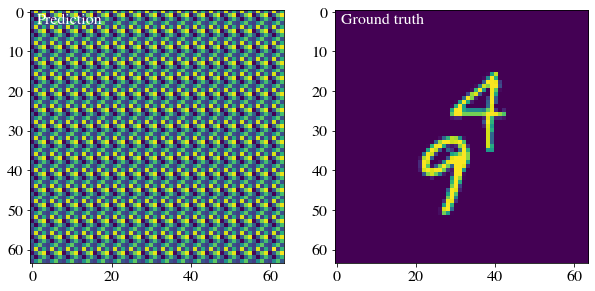

In [167]:
# Plot results
true_track = shape_to_img(data[itest, :, :, :, :], Npatch)

for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])

    plt.savefig('anim_%i.png' % (i+1))
    files.download('anim_%i.png' % (i+1))